In [1]:
!pip install tinydb 
!pip install pandas_ta
!pip install python-binance
# !pip install yfinance
!pip install mplfinance

  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218925 sha256=6b3766e4da897c0c35b939f0bf8114d4abba2a738d864e9159d8e360cb29d21a
  Stored in directory: c:\users\stb\appdata\local\pip\cache\wheels\54\4a\75\06b8e63fce6f6d2c1baae5c208edb18eca128407b0c96e1153
Successfully built pandas-ta


In [240]:
from tinydb import TinyDB, Query
import os
import sys
import json
# from dotenv import load_dotenv
import asyncio
import threading
import datetime as dt
from multiprocessing import Pool, cpu_count

# Other modules
import pandas as pd
import pandas_ta as ta
from pandas.io import sql
import numpy as np
import matplotlib.pyplot as plt

# python-binance module
from binance.client import Client
from binance import BinanceSocketManager
from binance.enums import *

# BINANCE_KEY = os.getenv('BINANCE_KEY')
# BINANCE_SECRET = os.getenv('BINANCE_SECRET')
BINANCE_KEY = ''
BINANCE_SECRET = ''

# connect binance
client = Client(BINANCE_KEY, BINANCE_SECRET)

import time


In [241]:
def get_candlestick_one_token(symbol):
    df1 = pd.DataFrame(client.get_historical_klines(symbol,
                                                       client.KLINE_INTERVAL_1HOUR,
                                                       "7 day ago UTC"
                                                       ))
    df1.columns = ["Date", "Open", "High", "Low", "Close", "Volume",
                  "Close_time", "Qav", "Num_trades", "Taker_base_vol",
                  "Taker_quote_vol", "Is_best_match"]
    df_simple = df1[["Date", "Open", "High", "Low", "Close", "Volume"]]
    df_simple[["Open", "High", "Low", "Close", "Volume"]] = df_simple[["Open", "High", "Low", "Close", "Volume"]].apply(pd.to_numeric)
    df_simple['Date_readonly'] = df_simple['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
    df_simple['Date'] = pd.to_datetime(df_simple['Date'])
    df_simple['Date'] = df_simple['Date'].apply(mpl_dates.date2num)
    df_simple['Date'] = df_simple['Date']*1000000
    
    return df_simple
    

In [242]:
# for visualization
def plot_all(levels, df):    
  fig, ax = plt.subplots(figsize=(16, 9))   
#   candlestick_ohlc(ax,df.values,width=0.6, colorup='green', 
#     colordown='red', alpha=0.8)    
  candlestick_ohlc(ax,df.values,colorup='green')    
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)    
  for level in levels:        
    plt.hlines(level[1], xmin = df['Date'][level[0]], xmax = 
      max(df['Date']), colors='blue', linestyle='--')    
  fig.show()

In [243]:
#method 1: fractal candlestick pattern
# determine bullish fractal 
def is_support(df,i):  
  cond1 = df['Low'][i] < df['Low'][i-1]   
  cond2 = df['Low'][i] < df['Low'][i+1]   
  cond3 = df['Low'][i+1] < df['Low'][i+2]   
  cond4 = df['Low'][i-1] < df['Low'][i-2]  
  return (cond1 and cond2 and cond3 and cond4) 
# determine bearish fractal
def is_resistance(df,i):  
  cond1 = df['High'][i] > df['High'][i-1]   
  cond2 = df['High'][i] > df['High'][i+1]   
  cond3 = df['High'][i+1] > df['High'][i+2]   
  cond4 = df['High'][i-1] > df['High'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)
# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
  ave =  np.mean(df['High'] - df['Low'])    
  return np.sum([abs(value-level)<ave for _,level in levels])==0


In [244]:
#method 2: window shifting method
#using the same symbol as the first example above
def cal_support_resistance(symbol):
    # df_NEAR = get_candlestick_one_token(symbol)
    df = get_candlestick_one_token(symbol)
    # a list to store resistance and support levels
    levels = []
    for i in range(2, df.shape[0] - 2):  
      if is_support(df, i):    
        low = df['Low'][i]    
        if is_far_from_level(low, levels, df):      
          levels.append((i, low))  
      elif is_resistance(df, i):    
        high = df['High'][i]    
        if is_far_from_level(high, levels, df):      
          levels.append((i, high))
    pivots = []
    max_list = []
    min_list = []
    for i in range(5, len(df)-5):
      # taking a window of 9 candles
      high_range = df['High'][i-5:i+4]
      current_max = high_range.max()
      # if we find a new maximum value, empty the max_list 
      if current_max not in max_list:
        max_list = []
      max_list.append(current_max)
      # if the maximum value remains the same after shifting 5 times
      if len(max_list)==5 and is_far_from_level(current_max,pivots,df):
          pivots.append((high_range.idxmax(), current_max))

      low_range = df['Low'][i-5:i+5]
      current_min = low_range.min()
      if current_min not in min_list:
        min_list = []
      min_list.append(current_min)
      if len(min_list)==5 and is_far_from_level(current_min,pivots,df):
        pivots.append((low_range.idxmin(), current_min))
    return df , pivots

In [248]:
df , pivots = cal_support_resistance("GALAUSDT")

<ipython-input-241-8e14b8673da7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simple['Date_readonly'] = df_simple['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
<ipython-input-241-8e14b8673da7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simple['Date'] = pd.to_datetime(df_simple['Date'])
<ipython-input-241-8e14b8673da7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [249]:
values = []
for element in pivots:
    _, value =  element
    values.append(value)
values.sort()
values

[0.08526, 0.0963, 0.11003, 0.12313, 0.1385, 0.14675]

<ipython-input-242-048204290d91>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


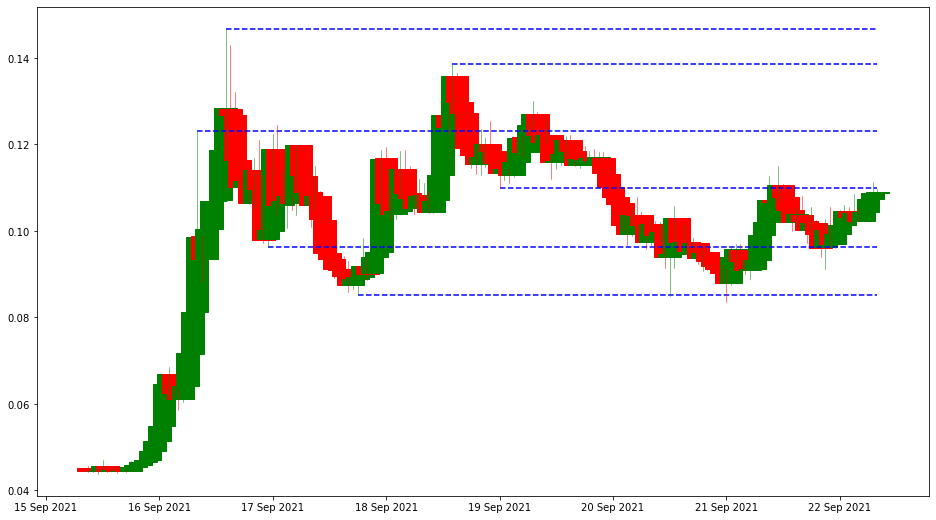

In [250]:
plot_all(pivots, df)